In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('mangrove_data.csv')

In [3]:
# Convert to datetime with timezone information
df['datetime'] = pd.to_datetime(df['datetime_with_tz'])

# Remove timezone information while keeping datetime type
df['datetime'] = df['datetime'].dt.tz_localize(None)

df = df.drop(columns={'datetime_with_tz'})

In [4]:
# Get list of all column names
all_columns = df.columns.tolist()

# Remove datetime and date from the current order
all_columns.remove('datetime')
all_columns.remove('date')

# Create new column order with datetime and date at the front
new_column_order = ['datetime', 'date'] + all_columns

# Reorder the DataFrame
df = df[new_column_order]

In [5]:
# Group by date and calculate mean for numeric columns
df = df.groupby('date').mean(numeric_only=True)

# Reset index to make date a column again
df = df.reset_index()

df['date'] = pd.to_datetime(df['date'])

In [6]:
df.head()

,date,gage_height,discharge,discharge_tf,salinity,specific_conductance,temperature,stream_water_level,tide_verified,wind_speed,wind_direction,wind_gust,air_temp,oxygen,turbidity,ph,ndvi
0,2024-03-01,6.250000,-6.302727,2.538636,31.818182,48772.727273,23.913636,-0.870000,1.662727,5.858182,104.500000,10.223182,75.304545,9.286364,4.654545,7.772727,0.335371
1,2024-03-02,6.297917,1.899583,4.304167,31.958333,48912.500000,24.570833,-0.822083,1.604167,5.418333,133.708333,9.030417,75.920833,8.637500,5.037500,7.695833,0.223780
2,2024-03-03,6.238261,8.936957,6.643478,32.173913,49143.478261,24.695652,-0.881739,1.536522,3.642609,142.434783,6.069565,76.326087,7.273913,6.152174,7.486957,0.022109
3,2024-03-04,6.172083,5.661250,4.322083,32.458333,49512.500000,24.375000,-0.947917,1.515000,3.644167,90.041667,5.905000,76.608333,6.812500,6.650000,7.454167,0.123293
4,2024-03-05,6.308333,5.687083,2.657083,32.458333,49458.333333,24.529167,-0.811667,1.633333,4.422917,111.500000,7.701667,77.429167,6.137500,6.812500,7.395833,0.499132


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  250 non-null    datetime64[ns]
 1   gage_height           250 non-null    float64       
 2   discharge             250 non-null    float64       
 3   discharge_tf          250 non-null    float64       
 4   salinity              250 non-null    float64       
 5   specific_conductance  250 non-null    float64       
 6   temperature           250 non-null    float64       
 7   stream_water_level    250 non-null    float64       
 8   tide_verified         250 non-null    float64       
 9   wind_speed            242 non-null    float64       
 10  wind_direction        242 non-null    float64       
 11  wind_gust             242 non-null    float64       
 12  air_temp              250 non-null    float64       
 13  oxygen              

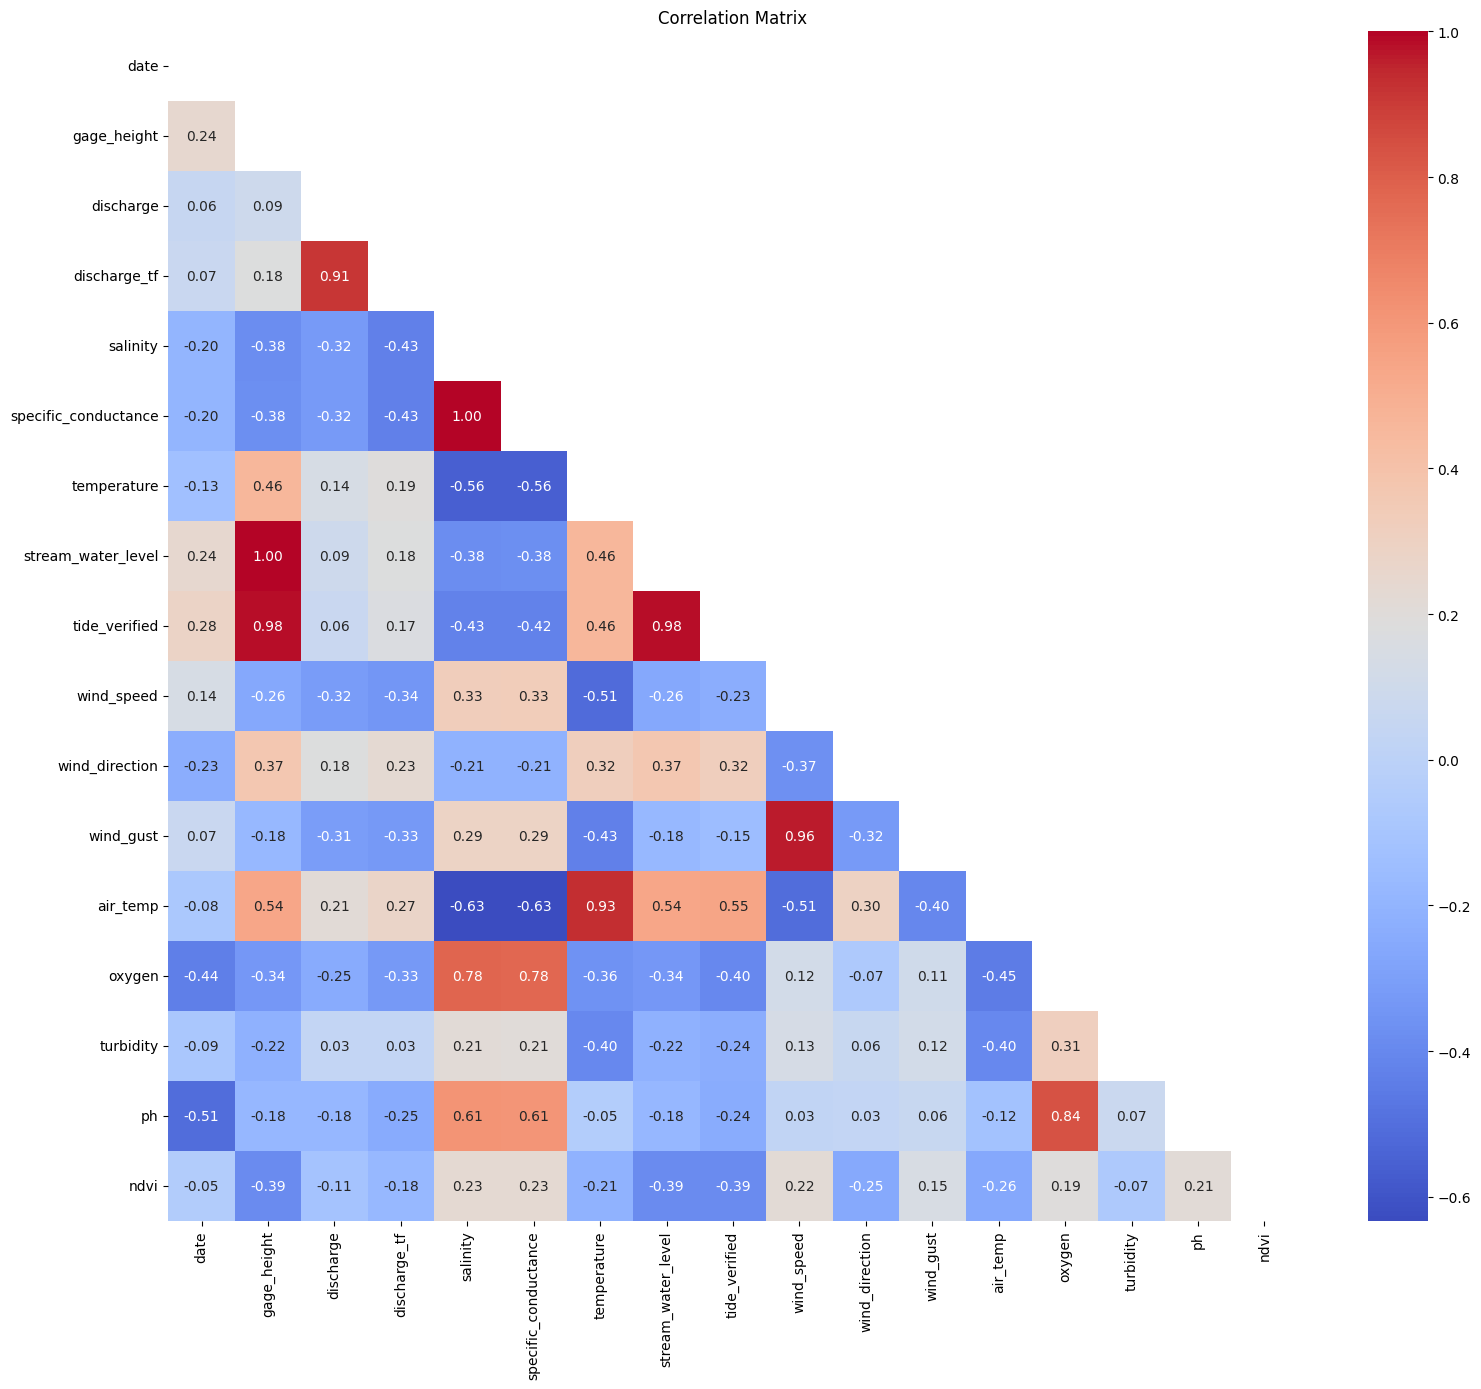

In [8]:
# 1. Exploratory Analysis
# Correlation heatmap to identify relationships
plt.figure(figsize=(16, 14))
correlation_matrix = df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

In [9]:
# Look at top correlations with NDVI
ndvi_correlations = correlation_matrix['ndvi'].sort_values(ascending=False)
print("Top correlations with NDVI:")
print(ndvi_correlations)

Top correlations with NDVI:
ndvi                    1.000000
salinity                0.231982
specific_conductance    0.230520
wind_speed              0.220088
ph                      0.212706
oxygen                  0.192580
wind_gust               0.150285
date                   -0.051247
turbidity              -0.065211
discharge              -0.111430
discharge_tf           -0.179658
temperature            -0.206134
wind_direction         -0.250732
air_temp               -0.261280
gage_height            -0.385263
stream_water_level     -0.385263
tide_verified          -0.386969
Name: ndvi, dtype: float64


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 2. Check for multicollinearity using VIF
# Handle missing values first - either drop or impute
df_no_missing = df.dropna()

# Select only numeric features excluding the target (NDVI)
X = df_no_missing.select_dtypes(include=[np.number])
X = X.drop(columns=['ndvi'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))


Variance Inflation Factors:
                Variable          VIF
0            gage_height  3803.937466
4   specific_conductance  3132.357462
3               salinity  3131.171551
7          tide_verified    39.274982
6     stream_water_level    39.081561
8             wind_speed    19.902000
10             wind_gust    17.756190
11              air_temp    12.225804
5            temperature     9.490407
12                oxygen     9.286390
2           discharge_tf     7.631473
1              discharge     7.084987
14                    ph     6.501753
13             turbidity     1.702079
9         wind_direction     1.522454


In [11]:
# Features with VIF > 5 or 10 indicate potential multicollinearity
high_vif_features = vif_data[vif_data["VIF"] > 5]
print(f"\nFeatures with high multicollinearity (VIF > 5):")
print(high_vif_features)


Features with high multicollinearity (VIF > 5):
                Variable          VIF
0            gage_height  3803.937466
1              discharge     7.084987
2           discharge_tf     7.631473
3               salinity  3131.171551
4   specific_conductance  3132.357462
5            temperature     9.490407
6     stream_water_level    39.081561
7          tide_verified    39.274982
8             wind_speed    19.902000
10             wind_gust    17.756190
11              air_temp    12.225804
12                oxygen     9.286390
14                    ph     6.501753


In [12]:
from statsmodels.formula.api import ols

# 3. Build a linear regression model to check significance
model = ols('ndvi ~ ' + ' + '.join(X.columns), data=df_no_missing).fit()
print("\nRegression Model Summary:")
print(model.summary())


Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:                   ndvi   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.088
Date:                Sun, 16 Mar 2025   Prob (F-statistic):           3.29e-10
Time:                        17:27:30   Log-Likelihood:                 71.492
No. Observations:                 242   AIC:                            -113.0
Df Residuals:                     227   BIC:                            -60.65
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Inter

In [13]:
# Function to calculate VIF scores
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# Step 1: Drop the most collinear variables first
# Based on correlation matrix, remove one from each highly correlated pair
variables_to_keep = df.drop(columns=[
    'specific_conductance',  # Almost perfect correlation with salinity
    'stream_water_level',    # Almost perfect correlation with gage_height
    'wind_gust',             # High correlation with wind_speed
    'air_temp'               # High correlation with temperature
]).columns.tolist()

In [14]:
# Step 2: Check VIF after first reduction
X = df[variables_to_keep].select_dtypes(include=[np.number]).dropna()

# Select only numeric features excluding the target (NDVI)
X = X.select_dtypes(include=[np.number])
X = X.drop(columns=['ndvi'])




In [15]:
X = X.drop(columns=['ph'])

print("VIF after removing highly correlated variables:")
vif_result = calculate_vif(X)
print(vif_result)

VIF after removing highly correlated variables:
         Variable         VIF
0     gage_height  689.649881
4     temperature  174.148237
5   tide_verified  137.665019
3        salinity   31.918320
8          oxygen   26.530510
6      wind_speed    9.685547
7  wind_direction    9.495875
9       turbidity    9.306476
2    discharge_tf    8.398060
1       discharge    7.234223


In [16]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# Assuming df is your dataframe with all necessary columns
# Start with all variables from the VIF list
all_vars = ['gage_height', 'temperature', 'tide_verified', 'salinity', 
           'oxygen', 'wind_speed', 'wind_direction', 'turbidity', 
           'discharge_tf', 'discharge']

# Stepwise backward elimination
remaining_vars = all_vars.copy()
iteration_results = []


# Function to calculate VIF
def calculate_vif(X):
    # Add dropna() to handle missing values
    X = X.dropna()
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

# For the initial VIF calculation
X_initial = df[remaining_vars].select_dtypes(include=[np.number]).dropna()
initial_vif = calculate_vif(X_initial)

# For each iteration's VIF calculation
X = df[remaining_vars].select_dtypes(include=[np.number]).dropna()
vif_data = calculate_vif(X)

# For the final VIF calculation
if len(remaining_vars) > 1:
    X_final = df[remaining_vars].select_dtypes(include=[np.number]).dropna()
    final_vif = calculate_vif(X_final)
    print("\nFinal VIF values:")
    print(final_vif)

# Function to run OLS and get summary
def run_ols(variables, data):
    formula = 'ndvi ~ ' + ' + '.join(variables)
    model = ols(formula, data=data).fit()
    return model

print("Starting stepwise variable selection with all variables:")
print("=" * 80)

# Initial VIF calculation
X_initial = df[remaining_vars].select_dtypes(include=[np.number]).dropna()
initial_vif = calculate_vif(X_initial)
print("Initial VIF values:")
print(initial_vif)
print("\n")

# Initial model
initial_model = run_ols(remaining_vars, df)
print("Initial model summary:")
print(initial_model.summary().tables[1])  # Coefficient table
print(f"R-squared: {initial_model.rsquared:.4f}")
print(f"Adj R-squared: {initial_model.rsquared_adj:.4f}")
print("\n" + "=" * 80 + "\n")

iteration = 1
while len(remaining_vars) > 1:
    print(f"Iteration {iteration}")
    print("-" * 40)
    
    # Run model with current variables
    model = run_ols(remaining_vars, df)
    
    # Get p-values excluding intercept
    p_values = model.pvalues.drop('Intercept')
    
    # Find the least significant variable
    max_p_var = p_values.idxmax()
    max_p = p_values.max()
    
    # Calculate current VIF
    X = df[remaining_vars].select_dtypes(include=[np.number]).dropna()
    vif_data = calculate_vif(X)
    
    # Store results
    iteration_results.append({
        'iteration': iteration,
        'variables': remaining_vars.copy(),
        'removed_var': max_p_var if iteration > 1 else None,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'max_vif': vif_data['VIF'].max(),
        'max_p': max_p
    })
    
    # Print current results
    print(f"Current variables: {remaining_vars}")
    print(f"Least significant variable: {max_p_var} (p-value: {max_p:.4f})")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adj R-squared: {model.rsquared_adj:.4f}")
    print(f"Max VIF: {vif_data['VIF'].max():.4f}")
    print("\nVariable significance:")
    print(p_values.sort_values())
    
    print("\nVIF values:")
    print(vif_data)
    
    # Stop if all variables are significant or VIF is acceptable
    if max_p < 0.1 and vif_data['VIF'].max() < 10:
        print("\nAll remaining variables are significant and VIF values are acceptable.")
        break
    
    # Remove the least significant variable
    remaining_vars.remove(max_p_var)
    print(f"\nRemoved: {max_p_var}")
    print("-" * 40 + "\n")
    
    iteration += 1

# Final model
final_model = run_ols(remaining_vars, df)
print("\n" + "=" * 80)
print("FINAL MODEL")
print("=" * 80)
print("Final variables:", remaining_vars)
print("\nFinal model summary:")
print(final_model.summary().tables[1])
print(f"R-squared: {final_model.rsquared:.4f}")
print(f"Adj R-squared: {final_model.rsquared_adj:.4f}")

# Calculate final VIF if more than one variable remains
if len(remaining_vars) > 1:
    X_final = df[remaining_vars].select_dtypes(include=[np.number])
    final_vif = calculate_vif(X_final)
    print("\nFinal VIF values:")
    print(final_vif)


Final VIF values:
         Variable         VIF
0     gage_height  689.649881
1     temperature  174.148237
2   tide_verified  137.665019
3        salinity   31.918320
4          oxygen   26.530510
5      wind_speed    9.685547
6  wind_direction    9.495875
7       turbidity    9.306476
8    discharge_tf    8.398060
9       discharge    7.234223
Starting stepwise variable selection with all variables:
Initial VIF values:
         Variable         VIF
0     gage_height  689.649881
1     temperature  174.148237
2   tide_verified  137.665019
3        salinity   31.918320
4          oxygen   26.530510
5      wind_speed    9.685547
6  wind_direction    9.495875
7       turbidity    9.306476
8    discharge_tf    8.398060
9       discharge    7.234223


Initial model summary:
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9757      0.676      1.443      


Summary of all iterations:
   iteration     removed_var  r_squared  adj_r_squared     max_vif     max_p
0          1            None   0.215822       0.181875  689.649881  0.823656
1          2     temperature   0.215653       0.185226   46.529953  0.783446
2          3        salinity   0.215397       0.188458   25.938734  0.837450
3          4       discharge   0.215255       0.191780   13.437846  0.520711
4          5    discharge_tf   0.213868       0.193796   13.139292  0.643617
5          6  wind_direction   0.213150       0.196479   12.578033  0.259077
6          7          oxygen   0.208883       0.195530    7.776293  0.200213
7          8      wind_speed   0.203375       0.193333    5.895243  0.012034


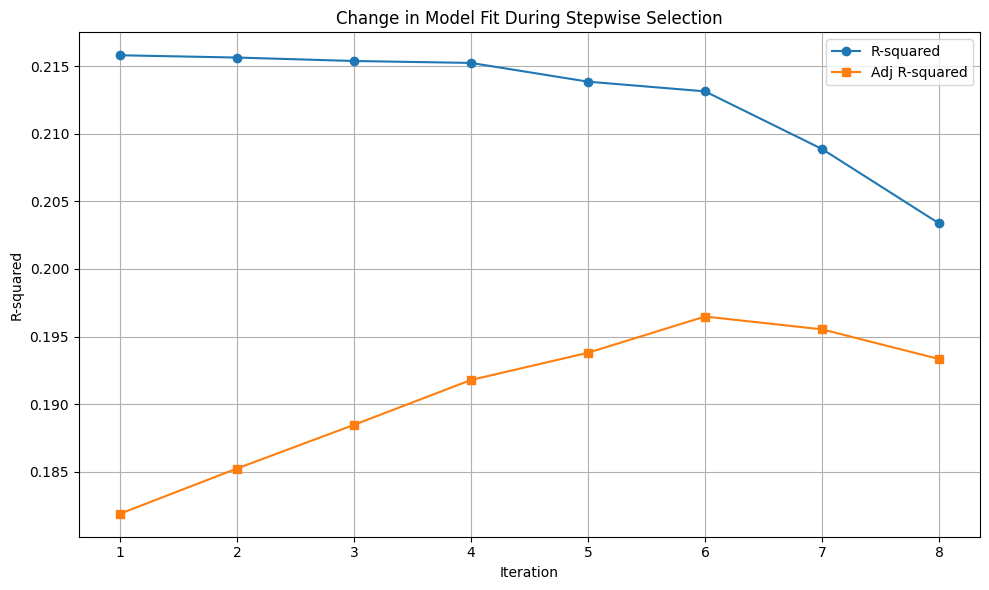

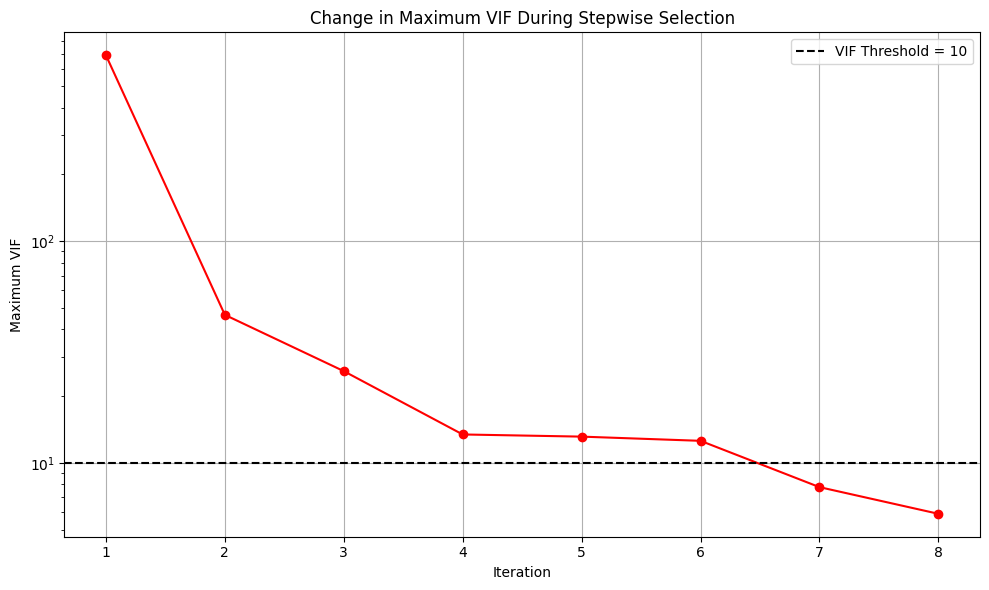

In [17]:
# Create summary table of all iterations
results_df = pd.DataFrame(iteration_results)
print("\nSummary of all iterations:")
print(results_df[['iteration', 'removed_var', 'r_squared', 'adj_r_squared', 'max_vif', 'max_p']])

# Plot R-squared and Adj R-squared trends
plt.figure(figsize=(10, 6))
plt.plot(results_df['iteration'], results_df['r_squared'], marker='o', label='R-squared')
plt.plot(results_df['iteration'], results_df['adj_r_squared'], marker='s', label='Adj R-squared')
plt.xlabel('Iteration')
plt.ylabel('R-squared')
plt.title('Change in Model Fit During Stepwise Selection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('stepwise_selection_rsquared.png')

# Plot max VIF trend
plt.figure(figsize=(10, 6))
plt.plot(results_df['iteration'], results_df['max_vif'], marker='o', color='red')
plt.xlabel('Iteration')
plt.ylabel('Maximum VIF')
plt.title('Change in Maximum VIF During Stepwise Selection')
plt.axhline(y=10, color='black', linestyle='--', label='VIF Threshold = 10')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('stepwise_selection_vif.png')

# Time Series

In [18]:
data = df.copy()[['date', 'tide_verified', 'turbidity', 'wind_speed', 'ndvi']]

In [19]:
# For cubic interpolation
data['wind_speed'] = data['wind_speed'].interpolate(method='cubic')

In [20]:
data.head()

,date,tide_verified,turbidity,wind_speed,ndvi
0,2024-03-01,1.662727,4.654545,5.858182,0.335371
1,2024-03-02,1.604167,5.037500,5.418333,0.223780
2,2024-03-03,1.536522,6.152174,3.642609,0.022109
3,2024-03-04,1.515000,6.650000,3.644167,0.123293
4,2024-03-05,1.633333,6.812500,4.422917,0.499132


In [21]:
data.tail()

,date,tide_verified,turbidity,wind_speed,ndvi
245,2024-12-16,1.722917,7.262500,12.972174,0.553465
246,2024-12-17,1.919167,9.175000,8.407500,0.252233
247,2024-12-18,1.973750,7.195833,5.070000,0.148073
248,2024-12-19,1.928000,6.010000,3.401500,0.101179
249,2024-12-30,2.270000,6.260000,2.370000,0.020223


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           250 non-null    datetime64[ns]
 1   tide_verified  250 non-null    float64       
 2   turbidity      250 non-null    float64       
 3   wind_speed     250 non-null    float64       
 4   ndvi           250 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 9.9 KB


In [23]:
data.to_csv('data.csv', index=False)

In [24]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from prophet import Prophet
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from xgboost import XGBRegressor
# from pmdarima import auto_arima

# # Load the data
# df = pd.read_csv('data.csv')
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')

# # Fill missing wind_speed values with cubic interpolation
# df['wind_speed'] = df['wind_speed'].interpolate(method='cubic')

# # Create lagged features (will be used for ML models)
# for i in range(1, 8):
#     df[f'wind_speed_lag_{i}'] = df['wind_speed'].shift(i)
#     df[f'tide_verified_lag_{i}'] = df['tide_verified'].shift(i)
#     df[f'turbidity_lag_{i}'] = df['turbidity'].shift(i)

# # Drop rows with NaN values from lag creation
# df_with_lags = df.dropna()

# # Split data into train and test (last 20% for testing)
# train_size = int(len(df) * 0.8)
# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# train_with_lags = df_with_lags.iloc[:train_size]
# test_with_lags = df_with_lags.iloc[train_size:]

# # 1. ARIMA Model
# def train_arima(train_data, test_data):
#     # Find best ARIMA parameters using auto_arima
#     print("Finding best ARIMA parameters...")
#     auto_model = auto_arima(train_data['wind_speed'], seasonal=False, 
#                           trace=True, error_action='ignore', suppress_warnings=True,
#                           stepwise=True, max_p=5, max_d=2, max_q=5)
    
#     best_order = auto_model.order
#     print(f"Best ARIMA order: {best_order}")
    
#     # Train ARIMA model
#     model = ARIMA(train_data['wind_speed'], order=best_order)
#     results = model.fit()
    
#     # Make predictions
#     forecast = results.forecast(steps=len(test_data))
    
#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(test_data['wind_speed'], forecast))
#     mae = mean_absolute_error(test_data['wind_speed'], forecast)
    
#     print(f"ARIMA RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
#     return forecast, results

# # 2. SARIMA Model (Seasonal ARIMA)
# def train_sarima(train_data, test_data):
#     # Adding seasonal component (assuming daily seasonality)
#     seasonal_order = (1, 1, 1, 7)  # (P,D,Q,s) where s is the seasonality
    
#     model = SARIMAX(train_data['wind_speed'], 
#                    order=(1, 1, 1),  # Use ARIMA order or customize
#                    seasonal_order=seasonal_order)
#     results = model.fit(disp=False)
    
#     # Make predictions
#     forecast = results.forecast(steps=len(test_data))
    
#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(test_data['wind_speed'], forecast))
#     mae = mean_absolute_error(test_data['wind_speed'], forecast)
    
#     print(f"SARIMA RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
#     return forecast, results

# # 3. Prophet Model
# def train_prophet(train_data, test_data):
#     # Prepare data for Prophet
#     prophet_train = train_data.reset_index()[['date', 'wind_speed']].rename(
#         columns={'date': 'ds', 'wind_speed': 'y'})
    
#     model = Prophet(daily_seasonality=True)
#     model.fit(prophet_train)
    
#     # Create future dataframe
#     future = pd.DataFrame(test_data.index, columns=['ds'])
    
#     # Make predictions
#     forecast = model.predict(future)
    
#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(test_data['wind_speed'], forecast['yhat']))
#     mae = mean_absolute_error(test_data['wind_speed'], forecast['yhat'])
    
#     print(f"Prophet RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
#     return forecast['yhat'].values, model

# # 4. Random Forest
# def train_rf(train_data, test_data):
#     # Features and target
#     X_train = train_data.drop('wind_speed', axis=1)
#     y_train = train_data['wind_speed']
#     X_test = test_data.drop('wind_speed', axis=1)
    
#     # Train model
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     model.fit(X_train, y_train)
    
#     # Make predictions
#     predictions = model.predict(X_test)
    
#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(test_data['wind_speed'], predictions))
#     mae = mean_absolute_error(test_data['wind_speed'], predictions)
    
#     print(f"Random Forest RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
#     return predictions, model

# # 5. XGBoost
# def train_xgboost(train_data, test_data):
#     # Features and target
#     X_train = train_data.drop('wind_speed', axis=1)
#     y_train = train_data['wind_speed']
#     X_test = test_data.drop('wind_speed', axis=1)
    
#     # Train model
#     model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
#     model.fit(X_train, y_train)
    
#     # Make predictions
#     predictions = model.predict(X_test)
    
#     # Calculate metrics
#     rmse = np.sqrt(mean_squared_error(test_data['wind_speed'], predictions))
#     mae = mean_absolute_error(test_data['wind_speed'], predictions)
    
#     print(f"XGBoost RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
#     return predictions, model

# # Train all models
# print("Training ARIMA model...")
# arima_pred, arima_model = train_arima(train_df, test_df)

# print("\nTraining SARIMA model...")
# sarima_pred, sarima_model = train_sarima(train_df, test_df)

# print("\nTraining Prophet model...")
# prophet_pred, prophet_model = train_prophet(train_df, test_df)

# print("\nTraining Random Forest model...")
# rf_pred, rf_model = train_rf(train_with_lags, test_with_lags)

# print("\nTraining XGBoost model...")
# xgb_pred, xgb_model = train_xgboost(train_with_lags, test_with_lags)

# # Create ensemble prediction (simple average)
# # Ensure all predictions have the same length
# min_length = min(len(arima_pred), len(sarima_pred), len(prophet_pred), len(rf_pred), len(xgb_pred))
# ensemble_pred = (arima_pred[:min_length] + sarima_pred[:min_length] + 
#                 prophet_pred[:min_length] + rf_pred[:min_length] + xgb_pred[:min_length]) / 5

# # Calculate ensemble metrics
# ensemble_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], ensemble_pred))
# ensemble_mae = mean_absolute_error(test_df['wind_speed'][:min_length], ensemble_pred)

# print("\nEnsemble RMSE: {:.4f}, MAE: {:.4f}".format(ensemble_rmse, ensemble_mae))

# # Plot results
# plt.figure(figsize=(12, 6))
# plt.plot(test_df.index[:min_length], test_df['wind_speed'][:min_length], label='Actual')
# plt.plot(test_df.index[:min_length], arima_pred[:min_length], label='ARIMA')
# plt.plot(test_df.index[:min_length], sarima_pred[:min_length], label='SARIMA')
# plt.plot(test_df.index[:min_length], prophet_pred[:min_length], label='Prophet')
# plt.plot(test_df.index[:min_length], rf_pred[:min_length], label='Random Forest')
# plt.plot(test_df.index[:min_length], xgb_pred[:min_length], label='XGBoost')
# plt.plot(test_df.index[:min_length], ensemble_pred, label='Ensemble', linewidth=2)

# plt.title('Wind Speed Forecasting: Model Comparison')
# plt.xlabel('Date')
# plt.ylabel('Wind Speed')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('model_comparison.png')

# # Weighted ensemble based on individual model performance
# # Calculate weights based on inverse RMSE (better models get higher weights)
# arima_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], arima_pred[:min_length]))
# sarima_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], sarima_pred[:min_length]))
# prophet_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], prophet_pred[:min_length]))
# rf_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], rf_pred[:min_length]))
# xgb_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], xgb_pred[:min_length]))

# # Calculate inverse RMSE
# inv_rmse = [1/arima_rmse, 1/sarima_rmse, 1/prophet_rmse, 1/rf_rmse, 1/xgb_rmse]
# weights = [w/sum(inv_rmse) for w in inv_rmse]

# print("\nModel weights based on performance:")
# model_names = ['ARIMA', 'SARIMA', 'Prophet', 'Random Forest', 'XGBoost']
# for model, weight in zip(model_names, weights):
#     print(f"{model}: {weight:.4f}")

# # Weighted ensemble prediction
# weighted_ensemble_pred = (
#     weights[0] * arima_pred[:min_length] +
#     weights[1] * sarima_pred[:min_length] +
#     weights[2] * prophet_pred[:min_length] +
#     weights[3] * rf_pred[:min_length] +
#     weights[4] * xgb_pred[:min_length]
# )

# # Calculate weighted ensemble metrics
# weighted_ensemble_rmse = np.sqrt(mean_squared_error(test_df['wind_speed'][:min_length], weighted_ensemble_pred))
# weighted_ensemble_mae = mean_absolute_error(test_df['wind_speed'][:min_length], weighted_ensemble_pred)

# print("\nWeighted Ensemble RMSE: {:.4f}, MAE: {:.4f}".format(weighted_ensemble_rmse, weighted_ensemble_mae))

# # Plot weighted ensemble comparison
# plt.figure(figsize=(12, 6))
# plt.plot(test_df.index[:min_length], test_df['wind_speed'][:min_length], label='Actual')
# plt.plot(test_df.index[:min_length], ensemble_pred, label='Simple Average Ensemble')
# plt.plot(test_df.index[:min_length], weighted_ensemble_pred, label='Weighted Ensemble')

# plt.title('Wind Speed Forecasting: Ensemble Comparison')
# plt.xlabel('Date')
# plt.ylabel('Wind Speed')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('ensemble_comparison.png')

# # Generate predictions for the missing data points
# # Identify the missing period
# missing_mask = df['wind_speed'].isna()
# missing_dates = df.index[missing_mask]

# if len(missing_dates) > 0:
#     print(f"\nGenerating predictions for {len(missing_dates)} missing data points")
    
#     # For demonstration, use the weighted ensemble approach to fill the missing values
#     # We would need to retrain the models on all available data
#     # For simplicity, let's assume we can use the existing models
    
#     # Prepare data for prediction
#     missing_df = df.loc[missing_dates]
    
#     # For each model, make predictions and combine with weights
#     # This is simplified - in practice you'd need to handle each model type specifically
    
#     print("Final ensemble predictions for missing values:")
#     print(missing_df)